# PostHoc Analysis

Post Hoc Analysis includes:
Interaction effects, non-linear effects, residual analysis, predictive power, model fit after outlier removal, geographic analysis, and comparison of decision tree machine learning model to linear regression model.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error


sns.set_theme(style="whitegrid")

In [3]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')


In [4]:
df = pd.read_csv('acs5y_2021_brfss_2021_merged.csv')

target = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diabetes
]

features = [
    'pct_dg_bb_int', # percentage of households with broadband internet
    "brfss_access2_ageadjprv", # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
    "brfss_checkup_ageadjprv", # percentage of adults aged >=18 years who had a checkup in the past 12 months
    "brfss_mhlth_ageadjprv", # percentage of adults aged >=18 years who report 14 or more days of poor mental health in the past 30 days
    "brfss_obesity_ageadjprv", # percentage of adults aged >=18 years who have obesity
    "pct_ed_lt9", # percentage of adults aged >=25 years with less than a 9th grade education
    "pct_ed_9_12", # percentage of adults aged >=25 years with a 9th to 12th grade education and no diploma
    "pct_ed_hs", # percentage of adults aged >=25 years with a high school diploma or GED
    "pct_ed_asc", # percentage of adults aged >=25 years with an associate's degree
    "pct_age_gte65", # percentage of adults aged >=65 years
    "pct_occ_unemp", #  percentage of employed adults aged >=16 years who are unemployed
    "pct_ses_pov",  # percentage of all people in poverty
    "pct_tp_veh_0", # percentage of households with zero vehicles
]

# Interaction Effects
Testing for interaction effects between predictors to see if the effect of one predictor on the target variable depends on the level of another predictor.

In [5]:
#Interaction Terms
df['int_bb_edu'] = df['pct_dg_bb_int'] * df['pct_ed_hs']
df['int_bb_unemp'] = df['pct_dg_bb_int'] * df['pct_occ_unemp']
df['int_bb_pov'] = df['pct_dg_bb_int'] * df['pct_ses_pov']
df['int_obesity_pov'] = df['brfss_obesity_ageadjprv'] * df['pct_ses_pov']

pred_plus_interactions = sm.add_constant(df[features + [
    'int_bb_edu',
    'int_bb_unemp', 
    'int_bb_pov', 
    'int_obesity_pov'
]])

# Fit and summarize OLS model
mod = sm.OLS(df[target], pred_plus_interactions)
res = mod.fit()
print(res.summary())


                               OLS Regression Results                               
Dep. Variable:     brfss_diabetes_ageadjprv   R-squared:                       0.911
Model:                                  OLS   Adj. R-squared:                  0.911
Method:                       Least Squares   F-statistic:                     1851.
Date:                      Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                              14:02:13   Log-Likelihood:                -3145.8
No. Observations:                      3076   AIC:                             6328.
Df Residuals:                          3058   BIC:                             6436.
Df Model:                                17                                         
Covariance Type:                  nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

# Non-Linear Effects
Testing for non-linear effects between predictors to see if the effect of one predictor on the target variable depends on the level of another predictor.

In [6]:
poly = PolynomialFeatures(degree=2, include_bias=False)

predictors = [
    'pct_dg_bb_int', # percentage of households with broadband internet
    'brfss_access2_ageadjprv', # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
    'pct_ses_pov',  # percentage of all people in poverty
    'brfss_obesity_ageadjprv', # percentage of adults aged >=18 years who have obesity
]

poly_pred = poly.fit_transform(df[predictors])
poly_pred = pd.DataFrame(poly_pred, columns=poly.get_feature_names_out(predictors))

df_poly = pd.concat([df, poly_pred], axis=1)

pred_with_poly = sm.add_constant(df_poly[features + 
                                         list(poly_pred.columns[3:])])

model = sm.OLS(df[target], pred_with_poly)
res = model.fit()
print(res.summary())


                               OLS Regression Results                               
Dep. Variable:     brfss_diabetes_ageadjprv   R-squared:                       0.914
Model:                                  OLS   Adj. R-squared:                  0.913
Method:                       Least Squares   F-statistic:                     1404.
Date:                      Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                              14:02:13   Log-Likelihood:                -3107.2
No. Observations:                      3076   AIC:                             6262.
Df Residuals:                          3052   BIC:                             6407.
Df Model:                                23                                         
Covariance Type:                  nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

# Residual Analysis
A more detailed examination of residuals to identify any outliers or leverage points that could be unduly influencing the model.

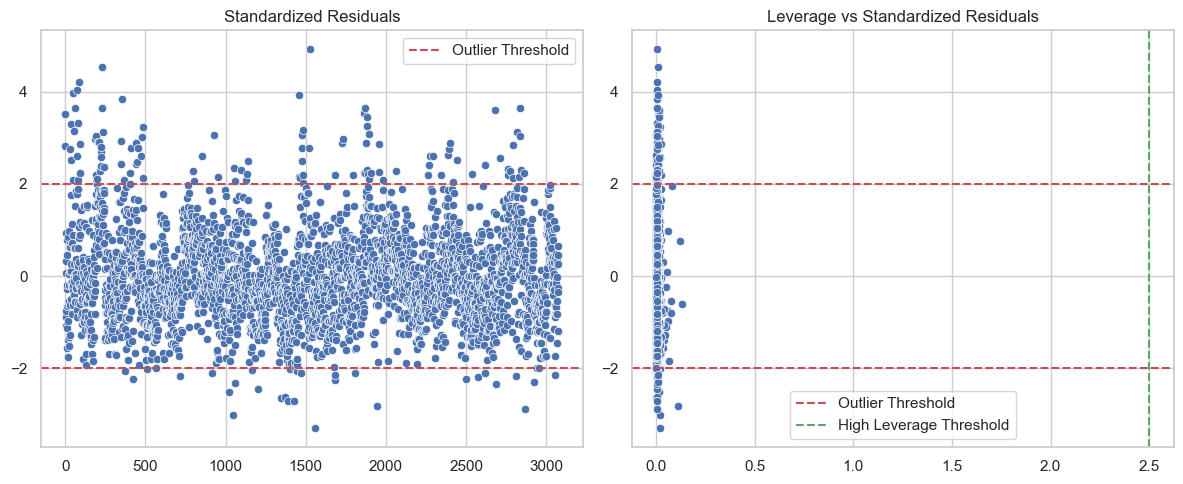

,totalpopulation,brfss_access2_ageadjprv,brfss_access2_crdprv,brfss_checkup_ageadjprv,brfss_checkup_crdprv,brfss_csmoking_ageadjprv,brfss_csmoking_crdprv,brfss_depression_ageadjprv,brfss_depression_crdprv,brfss_diabetes_ageadjprv,...,moe_tp_veh_0,moe_tp_veh_1,moe_tp_veh_2,moe_tp_veh_3,pct_dg_bb_int,moe_dg_bb_int,int_bb_edu,int_bb_unemp,int_bb_pov,int_obesity_pov
0,3398,16.9,16.5,60.7,60.7,18.6,19.3,13.1,13.0,12.6,...,4.0,4.5,3.6,2.2,57.5,4.0,2392.00,201.25,770.50,419.42
1,5059,13.7,13.4,61.6,60.6,15.5,16.7,13.4,13.5,10.9,...,2.9,5.0,6.2,2.7,77.0,4.6,3341.80,238.70,639.10,251.49
3,18557,19.2,19.1,62.6,61.2,35.4,35.5,21.2,21.9,15.9,...,2.8,3.1,2.2,1.3,74.8,2.0,3485.68,845.24,2131.80,1228.35
11,2332,12.4,11.3,63.0,68.6,21.4,20.6,20.4,18.6,10.0,...,5.8,4.2,4.8,3.1,59.4,6.3,2168.10,570.24,522.72,339.68
16,8360,23.0,23.3,61.7,59.5,42.8,42.8,23.7,24.7,19.6,...,3.0,2.4,1.6,1.2,70.0,3.5,3892.00,987.00,2562.00,1786.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,10763,11.0,10.9,77.5,78.4,20.4,19.9,19.2,19.0,13.2,...,3.1,4.2,3.8,4.4,74.2,3.8,2990.26,222.60,779.10,444.15
2870,35647,10.3,9.9,73.8,75.8,21.6,20.8,26.3,25.7,11.2,...,1.9,3.5,3.3,3.0,68.1,3.4,2301.78,340.50,1341.57,856.95
2921,4582,8.9,7.9,61.1,68.9,15.9,14.3,27.3,24.5,8.9,...,2.0,4.9,6.1,5.3,81.5,4.7,2420.55,138.55,863.90,365.70
2924,47873,8.2,8.2,66.4,63.6,14.0,11.2,27.6,29.5,9.7,...,1.7,2.5,2.5,1.5,84.6,1.9,1294.38,372.24,2089.62,866.97


In [7]:
model = sm.OLS(df[target], df[features])
res = model.fit()

influence = OLSInfluence(res)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

diagnostics_df = pd.DataFrame({
    'Standardized Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks Distance': cooks_d
})

# Plot standardized residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()

# Plot leverage vs. standardized residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=leverage, y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axvline(x=2*(len(predictors)+1)/len(predictors), color='g', linestyle='--', label='High Leverage Threshold')
plt.title('Leverage vs Standardized Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Identify observations with high Cook's distance
high_cooks_d_obs = diagnostics_df[diagnostics_df['Cooks Distance'] > 4/len(df)]
high_cooks_d_observations = df.loc[high_cooks_d_obs.index]


high_cooks_d_observations_idx = high_cooks_d_observations.index
high_cooks_d_observations

The standardized residuals plot shows several points outside the +/- 2 range, which are potential outliers.
The leverage vs. standardized residuals plot indicates a few observations with high leverage. The green vertical line marks the threshold above which leverage is considered high (2 times the number of predictors plus 1, divided by the number of observations).
The table at the end lists observations with high Cook's distance. Cook's distance measures the influence of each observation on the fitted response values. A common rule of thumb is that an observation with a Cook's distance larger than 4/n (where n is the number of observations) may be considered influential.

# Predictive Power
Evaluating the model's predictive performance using cross-validation or other out-of-sample testing methods.

In [8]:
model = LinearRegression()

cv_r2 = cross_val_score(model, df[features], df[target], cv=5, scoring='r2')
cv_rmse = cross_val_score(model, df[features], df[target], cv=5, scoring='neg_root_mean_squared_error')
cv_abs_error = cross_val_score(model, df[features], df[target], cv=5, scoring='neg_mean_absolute_error')

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [0.8904517  0.85636361 0.91077798 0.88356441 0.89411948]
R2 Mean: 0.887055436688812
Cross-validated RMSE: [0.85635982 0.65229434 0.70999611 0.69768339 0.78470899]
RMSE Mean: 0.7402085304354336
Cross-validated MAE: [0.64327969 0.51612694 0.54849416 0.52825202 0.64786202]
MAE Mean: 0.5768029661134164


# Model fit after removing outliers
The model fit after removing outliers is as follows

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.921    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                4966.8715
Date:               2023-11-09 14:52         BIC:                5050.3794
No. Observations:   2878                     Log-Likelihood:     -2469.4  
Df Model:           13                       F-statistic:        2587.    
Df Residuals:       2864                     Prob (F-statistic): 0.00     
R-squared:          0.922                    Scale:              0.32729  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     -1.1658   0.3587  -3.2501 0.0012 -1.8691 -0.4625
pct_dg_bb_int             -0.0210   0.0024  -8.8389 0.0000 -0.0256 -0.0163
brfss_access2_ageadjprv    0.1113   0.0031  35.

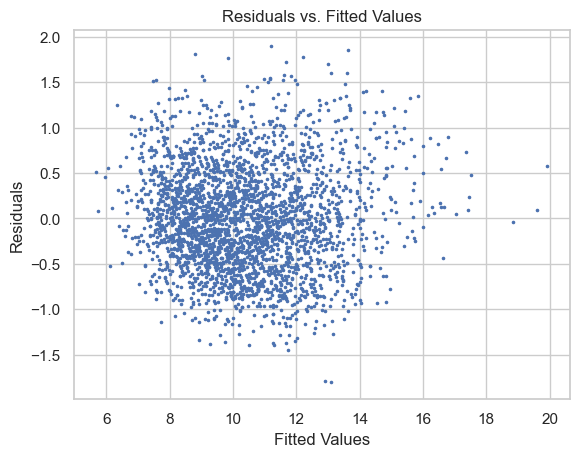

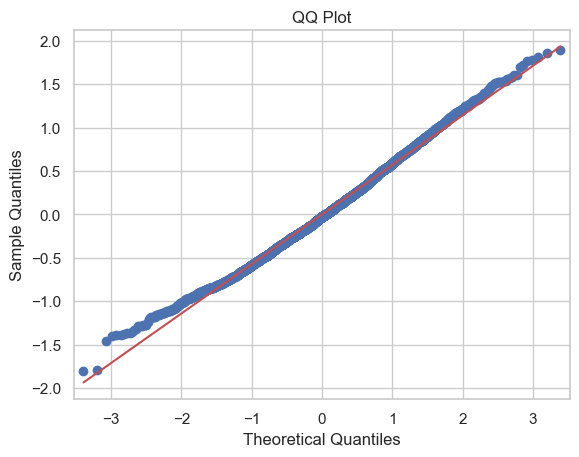

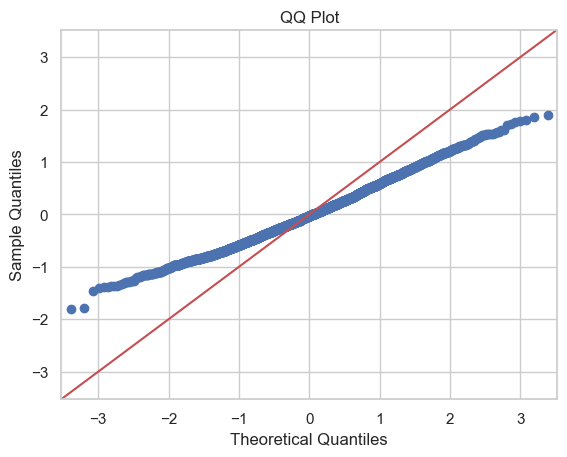

C:\Users\mfarm\AppData\Local\Temp\ipykernel_30936\88600368.py:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


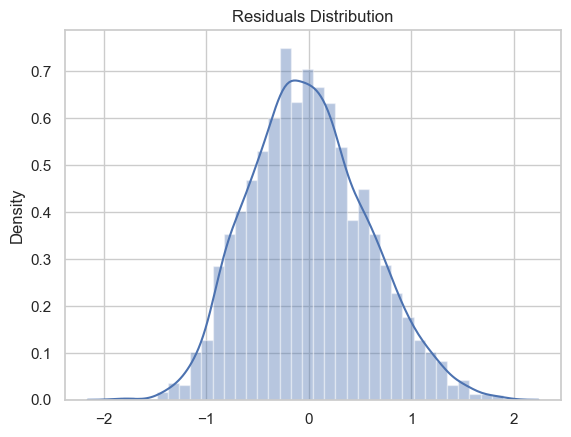

,MAE,R2,Adj R2,RMSE,AIC,BIC,F-Statistic,F-Statistic P-Value,No. Observations
0,NaN,0.92,0.92,0.57,4966.87,5050.38,2587.29,0.0,2878.0


In [25]:
#Remove outliers 
threshold = 4 / len(predictors)
non_inf_obs = df.drop(high_cooks_d_observations_idx)

new_target = non_inf_obs[target]
new_features = non_inf_obs[features]
#add constant
new_features = sm.add_constant(new_features)

new_model = sm.OLS(new_target, new_features)
new_res = new_model.fit()
mae = np.mean(np.abs(new_res.resid))
print(new_res.summary2())

#Plot residuals
residuals = new_res.resid
plt.scatter(new_res.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ
sm.qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

#qq w 45 line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot')
plt.show()

#dist plot of resdid
sns.distplot(residuals)
plt.title('Residuals Distribution')
plt.show()


#model fit table

fit_measures = pd.DataFrame()
fit_measures['MAE'] = mae
fit_measures['R2'] = [new_res.rsquared]
fit_measures['Adj R2'] = [new_res.rsquared_adj]
fit_measures['RMSE'] = [np.sqrt(new_res.mse_resid)]
fit_measures['AIC'] = [new_res.aic]
fit_measures['BIC'] = [new_res.bic]
fit_measures['F-Statistic'] = [new_res.fvalue]
fit_measures['F-Statistic P-Value'] = [new_res.f_pvalue]
fit_measures['No. Observations'] = [new_res.nobs]

display(fit_measures.round(2))


In [18]:
#use non_inf_obs for sklear linear regression OLS
model = LinearRegression()

cv_r2 = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='r2')
cv_rmse = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_root_mean_squared_error')
cv_abs_error = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_mean_absolute_error')

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [0.93032041 0.86652659 0.91201191 0.89448149 0.92632801]
R2 Mean: 0.9059336817425454
Cross-validated RMSE: [0.610492   0.57777959 0.60770564 0.58904278 0.61898988]
RMSE Mean: 0.6008019801265508
Cross-validated MAE: [0.49118005 0.46875329 0.49555551 0.4656945  0.51408996]
MAE Mean: 0.4870546590331726


# Comparison of original model to outlier-removed model
Adjusted R-squared: It increased to 0.921 from 0.905, indicating that the model explains 92.1% of the variability in the dependent variable after adjusting for the number of predictors. This suggests a better fit to the data compared to the previous model.

AIC/BIC: Both AIC and BIC are lower (4966.8715 and 5050.3794, respectively) compared to the previous model (6520.7477 and 6605.1871). These criteria suggest that the model's fit has improved after removing outliers.

Log-Likelihood: The log-likelihood value is higher (-2469.4 vs. -3246.4), which also indicates an improved model fit.

F-statistic: An increased F-statistic (2587 vs. 2256) with a p-value of 0.00 means the model is statistically significant and likely has a better overall fit.

Coefficient Changes: Most coefficients remain statistically significant but their values have changed slightly, indicating a refined estimate of the relationships between predictors and the dependent variable after the outliers' influence was reduced.

Intercept: The intercept is now a significant negative value (-1.1658), which could indicate that the baseline level of the dependent variable has shifted after outlier removal.

Diagnostics:

The Omnibus and Jarque-Bera tests still indicate a significant result, meaning the residuals are not normally distributed, yet QQ plot shows lack of severe violation of this assumption. The skewness and kurtosis values are closer to what would be expected in a normal distribution compared to the previous model.
The Durbin-Watson statistic (1.366) is still indicative of slight positive autocorrelation, which hasn't changed much and remains a consideration.
The Condition Number is still large, indicating potential multicollinearity among the predictors. VIF analysis shows all predictors less than 5. 

# Geographic Analysis
Organized by larger regions defined by the US Census Bureau. The regions are Northeast, Midwest, South, and West.

In [10]:
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

df['region'] = df['state'].apply(lambda x: [k for k, v in regions.items() if x in v][0])

unmapped = df[~df['region'].isin(regions.keys())]
unmapped['state'].unique()

array([], dtype=object)

In [11]:
def regression_by_region(region_name, data, predictors, target):
    region_data = data[data['region'] == region_name]
    region_target = region_data[target]
    region_features = region_data[predictors]
    region_features = sm.add_constant(region_features)
    region_model = sm.OLS(region_target, region_features).fit()
    #coef for broadband access
    bb_int_coef = region_model.params['pct_dg_bb_int']

    return region_model, bb_int_coef

region_coef = {}

for region in df['region'].unique():
    region_model, bb_int_coef = regression_by_region(region, df, features, target)
    region_coef[region] = bb_int_coef

region_coef

{'West': -0.024809516785207618,
 'South': -0.018677516111246947,
 'Northeast': -0.005597879117935188,
 'Midwest': -0.012884519145431275}

These coefficients suggest that an increase in broadband internet access is associated with a decrease in diabetes prevalence across all regions, with the strongest association observed in the West and the weakest in the Northeast.

These regional differences could be due to a variety of factors, including differences in urbanization, access to healthcare, lifestyle, and other region-specific characteristics that can affect health outcomes. The results support the idea that policy interventions might need to be tailored to regional contexts to be most effective.

Further analysis could involve exploring why these differences exist, potentially by examining interactions with other variables that could have region-specific effects on the relationship between broadband access and health outcomes.

# Machine Learning : Decision Tree

Uses a tree to predict the target variable. The tree is constructed by recursively splitting the data into smaller and smaller subsets, with each split chosen to maximize the reduction in the target variable's variance. The tree is grown until some stopping criterion is met, such as a minimum number of observations in each leaf node.

In [21]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    score = -cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_mean_absolute_error').mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best trial:', study.best_trial.params)
display(study.trials_dataframe().sort_values('value', ascending=False).head(10))

[I 2023-11-09 14:22:48,042] A new study created in memory with name: no-name-1012fe07-86dc-4520-9ee4-05203d8244f7
[I 2023-11-09 14:22:48,142] Trial 0 finished with value: 0.7074907683110356 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7074907683110356.
[I 2023-11-09 14:22:48,205] Trial 1 finished with value: 0.8141054646835542 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7074907683110356.
[I 2023-11-09 14:22:48,259] Trial 2 finished with value: 0.8562133688228556 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7074907683110356.
[I 2023-11-09 14:22:48,329] Trial 3 finished with value: 0.7679473459695156 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7074907683110356.
[I 2023-11-09 14:22:48,375] Trial 4 finished with value: 0.91430

Best trial: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}


,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_min_samples_leaf,params_min_samples_split,state
469,469,0.985769,2023-11-09 14:23:40.441722,2023-11-09 14:23:40.519234,0 days 00:00:00.077512,2,9,3,COMPLETE
286,286,0.985769,2023-11-09 14:23:18.409689,2023-11-09 14:23:18.477934,0 days 00:00:00.068245,2,4,10,COMPLETE
80,80,0.985769,2023-11-09 14:22:55.838210,2023-11-09 14:22:55.896208,0 days 00:00:00.057998,2,9,8,COMPLETE
37,37,0.985769,2023-11-09 14:22:51.445049,2023-11-09 14:22:51.503045,0 days 00:00:00.057996,2,10,10,COMPLETE
143,143,0.914306,2023-11-09 14:23:02.498108,2023-11-09 14:23:02.569436,0 days 00:00:00.071328,3,10,9,COMPLETE
334,334,0.914306,2023-11-09 14:23:24.098298,2023-11-09 14:23:24.179822,0 days 00:00:00.081524,3,10,9,COMPLETE
263,263,0.914306,2023-11-09 14:23:15.822491,2023-11-09 14:23:15.898006,0 days 00:00:00.075515,3,10,3,COMPLETE
4,4,0.914306,2023-11-09 14:22:48.330256,2023-11-09 14:22:48.375251,0 days 00:00:00.044995,3,2,10,COMPLETE
5,5,0.914306,2023-11-09 14:22:48.376253,2023-11-09 14:22:48.425783,0 days 00:00:00.049530,3,7,9,COMPLETE
6,6,0.914306,2023-11-09 14:22:48.426787,2023-11-09 14:22:48.473782,0 days 00:00:00.046995,3,8,7,COMPLETE


In [22]:
decision_tree = DecisionTreeRegressor(**study.best_trial.params)

cv_r2 = cross_val_score(decision_tree, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='r2')
cv_rmse = cross_val_score(decision_tree, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_root_mean_squared_error')
cv_abs_error = cross_val_score(decision_tree, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_mean_absolute_error')

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [0.85055105 0.69497447 0.83857899 0.77669316 0.78406541]
R2 Mean: 0.7889726143834033
Cross-validated RMSE: [0.89354407 0.87343968 0.82260454 0.85488952 1.05972567]
RMSE Mean: 0.9008406959265198
Cross-validated MAE: [0.67874731 0.68358052 0.62079844 0.66850323 0.80824279]
MAE Mean: 0.6919744570167605


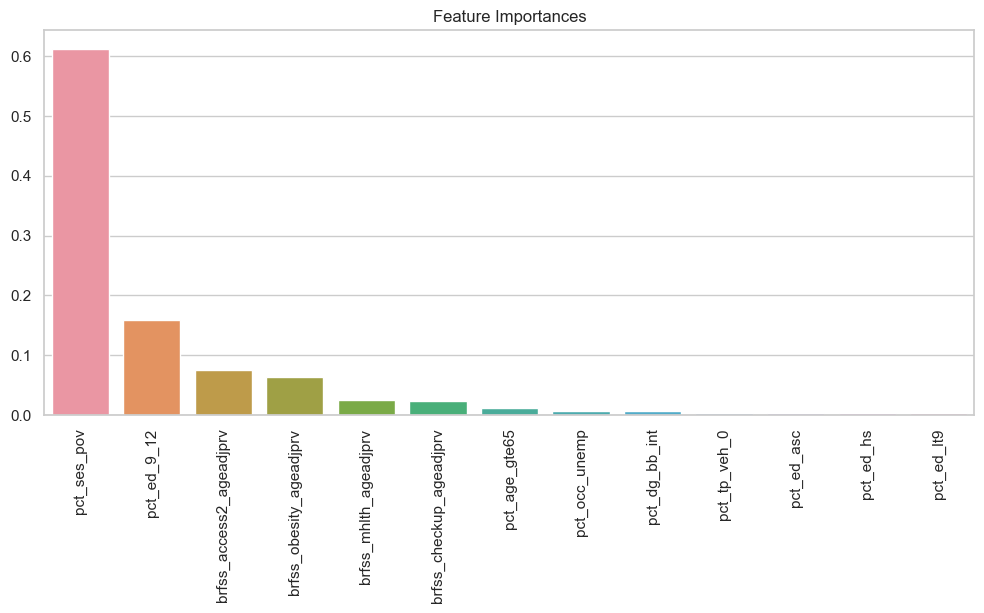

In [23]:
#feature importance
decision_tree.fit(df[features], df[target])
importances = decision_tree.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(features)[indices]

plt.figure(figsize=(12, 5))
plt.title('Feature Importances')
sns.barplot(x=feature_names, y=importances[indices])
plt.xticks(rotation=90)
plt.show()


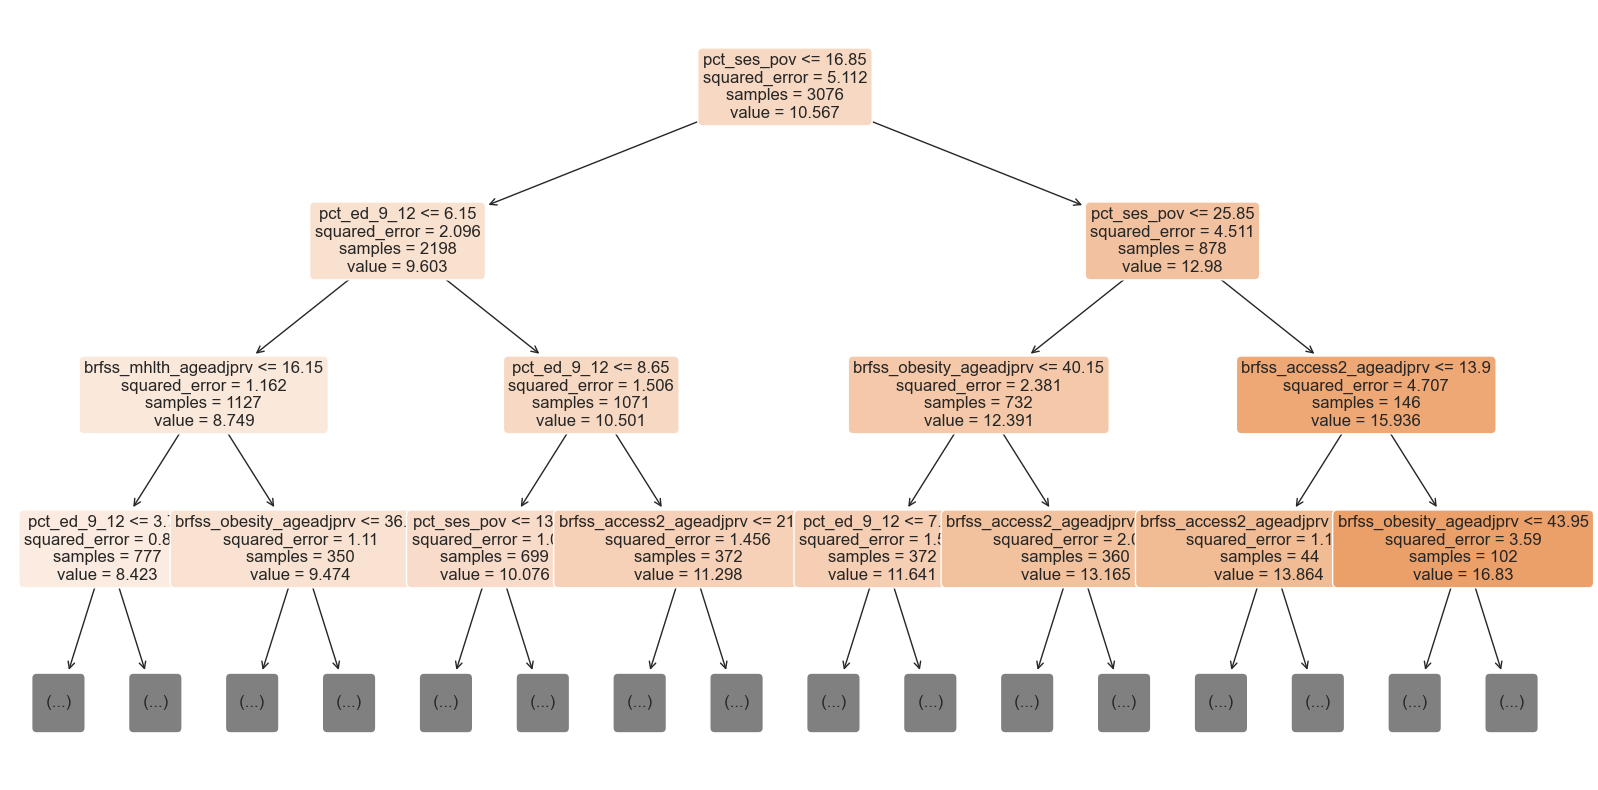

In [15]:
#plot tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree,
          feature_names=features,
          filled=True,
          fontsize=12, 
          class_names=target,
          rounded=True, 
          max_depth=3)
plt.show()


In [20]:
#import mlp
from sklearn.neural_network import MLPRegressor






[I 2023-11-09 14:14:04,545] A new study created in memory with name: no-name-1f081eab-e7db-4ef8-8ec5-99eb74b31804
C:\Users\mfarm\AppData\Local\Temp\ipykernel_30936\2269586760.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
[I 2023-11-09 14:14:06,469] Trial 0 finished with value: 0.585596831746696 and parameters: {'max_depth': 3, 'learning_rate': 0.02968973684718619, 'n_estimators': 404}. Best is trial 0 with value: 0.585596831746696.
C:\Users\mfarm\AppData\Local\Temp\ipykernel_30936\2269586760.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_ra

KeyboardInterrupt: 